# Image Classification on Imagenette:

## Problem Statement

_FengYi can you manage this section?_





### Packages

We use [livelossplot](https://github.com/stared/livelossplot) to graph our accuracy and loss live.

In [ ]:
!pip install livelossplot --quiet

In [2]:
import numpy as np    
import matplotlib.pyplot as plt       
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from livelossplot import PlotLosses



Mounts the drive so that the model can access pretrained models and save the latest ones. 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Location where the best model is saved
path = '/content/drive/MyDrive/Colab Notebooks/best_network.pth'

# Alternative path that stores the file in the Colab instance
# path = '/content/best_network.pth'

# Location of a model you wish to restart from.
# 'load_path = None' if you wish to train the model from scratch
load_path = None

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Sources

We access our data source through fastAI. Link to the repository can be found [here](https://github.com/fastai/imagenette).

If you plan on training the network via local files, you will need to change the source to match where you are locally storing the /train and /val files.


In [ ]:
# Google Colab
from fastai.vision.all import *
set_seed(42, reproducible= True)
source = untar_data(URLs.IMAGENETTE)

## Exploratory Data Analysis

**Data Exploration**

"Provide details about number of classes, few examples, etc. Some data preparation
is done, clear what has been done and why, code is clear."

**Image Preprocessing**

_@William you're in charge of this entire section._

In [3]:
classes = ("Tench", "English Springer", "Cassette Player", "Chain Saw", "Church", "French Horn", "Garbage Truck", "Gas Pump", "Golf Ball", "Parachute")

#  Image Hyperparameters
batch_size = 32
width = 224
mean = [0.4655, 0.4546, 0.4251]
std = [0.2775, 0.2725, 0.2938]

def load_data():
  train = source/"train"
  val = source/"val"

  train_dataset = ImageFolder(
    train,
    transforms.Compose([
        transforms.Resize(280),
        transforms.RandomCrop(width), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomErasing()
    ]))

  val_dataset = ImageFolder(
    val,
    transforms.Compose([
        transforms.Resize(280),
        transforms.RandomCrop(width), 
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]))

  train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size)
  
  return train_dataloader, val_dataloader

## Model

**Preface**

After researching popular neural networks used for image classification, we began our approach to the problem by replicating GoogLeNet and various versions of ResNet such as ResNet34, ResNet50, and ResNet50-d as proposed by He et al. 2019. Our experiment showed that the ResNet models delivered a higher accuracy than GoogLeNet for the ImageNette dataset. We then attempted to boost the accuracy of our model using ResNet as a foundation through various aspects such as modifying the internal architecture to bring in features from other models that we thought might make an improvement, replacing specific features such as the activation function and pooling methods by those proposed in recent papers as better alternatives to the ones originally used, and experimenting with various components in the training cycle such as optimisers and the incorporation of learning rate schedulers. Our final model is a composition of various adjustments that experiments had shown to be successful at increasing the test accuracy on the ImageNette dataset.  

**Iterations**

Throughout our experimentation, we experimented on different kinds of models and tested each of them based on the highest accuracy it gains after tuning hyperparameters. All iterations can be found in the `models.ipynb` file. Below is our most successful model.

**Block Structure**

ResNet bottlenecks allow information to be preserved as it passes through the neural network by using shortcut connections that connect the identity of each bottleneck and appends it to the result of a set off convolutions. Our model builds upon this by merging 2 divergent sets of convolutions and the identity into a combined output under the assumption that performing 2 passes on the input would draw out more information compared to using either by themselves. 

However, doing so comes with their own set of problems.

1. Adding _n_ passes increases computation and space required for each block _n_ times. 

2. Trying to combine completely different convolutions will yield completely divergent results that causes the network to not learn.

Hence, we chose to use an inverted residual block from MobileNetV2 to pair with our standard residual block as it performs similarly to a standard residual block but is also more memory efficient. 


In [5]:
class block(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, expansion=6, downsample=None):
    super(block, self).__init__()
    middle_channels = in_channels*expansion

    # Residual Block
    self.pass1 = nn.Sequential(
        nn.Conv2d(in_channels, middle_channels, 1, stride=1, padding=0, bias=False), # pointwise
        nn.BatchNorm2d(middle_channels),
        nn.Mish(),
        nn.Conv2d(middle_channels, middle_channels, 3, stride=stride, padding=1, bias=False), # normal 3x3 convolution
        nn.BatchNorm2d(middle_channels),
        nn.Mish(),
        nn.Conv2d(middle_channels, out_channels, 1, stride=1, padding=0, bias=False), # pointwise
        nn.BatchNorm2d(out_channels),
        nn.Mish(),
    )

    # Inverted Residual Block 
    self.pass2 = nn.Sequential(
        nn.Conv2d(in_channels, middle_channels, kernel_size=1, stride=1, padding=0, bias=False), # pointwise
        nn.BatchNorm2d(middle_channels),
        nn.Mish(),
        nn.Conv2d(middle_channels, middle_channels, kernel_size=3, stride=stride, padding=1,groups=in_channels, bias=False), # depth-wise convolution
        nn.BatchNorm2d(middle_channels),
        nn.Mish(),
        nn.Conv2d(middle_channels, out_channels, kernel_size=1, stride=1, bias=False), # pointwise
        nn.BatchNorm2d(out_channels),
        nn.Mish(),
    )

    self.downsample = downsample
  
  def forward(self, x):
    identity = x.clone()
    x1 = self.pass1(x)
    x2 = self.pass2(x)
    x = x1 + x2
    if self.downsample is not None:
      identity = self.downsample(identity)
    x += identity
    return x

**Main Architecture**

Our implementation of the neural network builds upon this combined bottleneck and follows MobileNetV2’s architecture as its main structure. To simplify our implementation, we use the same number of intermediate channels for both passes and perform down sampling at the start of every block. Following the paper’s recommendation, we used an expansion rate of 6 for our intermediate channels within the blocks as recommended by (Sandler, Howard, Zhu, Zhmoginov, & Chen). We do not use dropout as experimental results show that it does not bring any major improvement in training accuracy while drastically increasing the training time. In addition, including dropout to all bottleneck convolutions causes our network to fail to learn. After every convolution, we employ batch normalization and use Mish as our activation function.

For Reference:


| Input        | Operator    | Repeats | Output | n_blocks | Stride |
|--------------|-------------|---------|--------|----------|--------|
| 224^2 x 3    | conv2d      | -       | 32     | 1        | 2      |
| 112^2 x 32   | bottleneck  | 1       | 16     | 1        | 1      |
| 112^2 x 16   | bottleneck  | 6       | 24     | 2        | 2      |
| 56^2 x 24    | bottleneck  | 6       | 32     | 3        | 2      |
| 28^2 x 32    | bottleneck  | 6       | 64     | 4        | 2      |
| 14^2 x 64    | bottleneck  | 6       | 96     | 3        | 1      |
| 14^2 x 96    | bottleneck  | 6       | 160    | 3        | 2      |
| 7^2 x 160    | bottleneck  | 6       | 320    | 1        | 1      |
| 7^2 x 320    | conv2d 1x1  | -       | 1280   | 1        | 1      |
| 7^2 x 1280   | avgpool 7x7 | -       | -      | 1        | -      |
| 1 x 1 x 1280 | conv2d 1x1  | -       | k      | -        |        |


Through our experimentations, we found that using Mish, a self-regularized non-monotonic activation function proposed by Misra (2019), outperforms ReLU and ReLU6 by converging significantly faster, a finding in line with the results of the original paper. However, the use of MaxBlurPool as an alternative to MaxPool as suggested by Zhang (2019) demonstrated inconsistent results to the claims made to improve model accuracy in the paper for our dataset, instead showed a decrease in accuracy compared to the original max pool. 

Dropout is another technique we tried that offered disappointing results, being a regularisation method frequently used to reduce overfitting on neural networks and thus improve accuracy and performance, it increased the training time drastically when incorporated into our network without either reduction in overfitting or improvements in accuracy.  

In [ ]:
class Network(nn.Module):
  def __init__(self, in_channels=3, num_classes=10):
    super(Network, self).__init__()

    # Structure follows MobileNetV2 block structure
    self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(32)
    self.mish = nn.Mish()

    self.block1 = self._make_layer(block, 1, 32, 16, 1, 1)
    self.block2 = self._make_layer(block, 6, 16, 24, 2, 2)
    self.block3 = self._make_layer(block, 6, 24, 32, 3, 2)
    self.block4 = self._make_layer(block, 6, 32, 64, 4, 2)
    self.block5 = self._make_layer(block, 6, 64, 96, 3, 1)
    self.block6 = self._make_layer(block, 6, 96, 160, 3, 2)
    self.block7 = self._make_layer(block, 6, 160, 320, 1, 1)
    
    self.conv2 = nn.Conv2d(320,1280, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(1280)
    self.avgPool = nn.AvgPool2d(7)
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(1280, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.mish(x)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.block6(x)
    x = self.block7(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.mish(x)
    x = self.avgPool(x)
    x = self.flatten(x)
    x = self.fc(x)
    x = F.log_softmax(x, dim=1)
    
    return x
  
  def _make_layer(self, block, expansion, in_channels, out_channels, repeats, stride):
    layers = []
    downsample = None

    # We downsample when there is a mismatch between the dimensions of the input and output
    if stride != 1 or in_channels != out_channels:
      downsample = nn.Sequential(
          nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride, bias=False),
          nn.BatchNorm2d(out_channels),
      )

    # Downsampling occurs only in the first block of each layer
    layers.append(
        block(in_channels, out_channels, stride, expansion, downsample)
    )

    # Append n-1 additional blocks to the layer
    for _ in range(repeats-1):
      layers.append(
          block(out_channels, out_channels, 1, expansion)
      )
    
    return nn.Sequential(*layers)


model = Network()

if load_path is not None:
  model.load_state_dict(torch.load(load_path))

## Main Training Loop

For our main loop, to calculate loss we used Cross Entropy Loss and for our optimizer we found that using Adam with an initial learning rate of 0.00024 and weight decay of 0.00001 outperforms SGD as recommended by (He, Zhang, Ren, & Sun, 2015) since it allows our model to initially converge faster. We used a mini-batch size of 32 as experimentation between 32, 64, 96, and 128 shows that while the time taken to train each epoch is inversely proportional to the batch size, it also causes our model to overfit earlier. Tests were also conducted to see if applying a learning rate scheduler improved our accuracy and we settled on using a cosine annealing schedule with T_max set to 10.

The use of a learning rate scheduler greatly reduced the number of epochs required to reach a test accuracy of 80%, upon comparison we settled with the cosine annealing scheduler. 



In [7]:
from torch.autograd import Variable
from torch.optim import Adam, SGD, lr_scheduler

# Function to save the model
def saveModel():
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy(device):
    model.eval()
    accuracy = 0.0
    total = 0.0

    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # run the model on the test set to predict labels
            outputs = model(images)

            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all validation images
    accuracy = (100 * accuracy / total)
    return(accuracy)

def trainAccuracy(device):

    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in train_loader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # run the model on the test set to predict labels
            outputs = model(images)

            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all training images
    accuracy = (100 * accuracy / total)
    return(accuracy)

def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    
    # Stores and generates plots
    liveloss = PlotLosses()

    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)
    model.train()

    # Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.00024, weight_decay = 0.00001)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
    all_accuracy = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        
        r_loss = 0.0
        r_correct = 0

        model.train()
        logs = {}
        for i, (images, labels) in enumerate(train_loader, 0):
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            running_loss += loss.item()     # extract the loss value
            r_loss += loss.detach() * images.size(0)

            # Print loss statistics every 10 batches
            if i % 10 == 10: # 10 means off
                print('[%d, %5d] loss: %.8f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy for this epoch when tested over all test images
        model.eval()
        accuracy = testAccuracy(device)
        train_accuracy = trainAccuracy(device)
        all_accuracy.append(accuracy)

        # Update the table
        logs['log loss'] = (r_loss / 9469).item()
        logs['val_'+ 'accuracy'] = accuracy
        logs['accuracy'] =  train_accuracy

        liveloss.update(logs)
        liveloss.send()

        print('For epoch', epoch+1,'the train accuracy is %d %%' % (train_accuracy), 'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # Saves the model if the accuracy is the better than the current
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

        # Iterate the scheduler
        scheduler.step()

    print('The average accuracy over %d' % num_epochs, ' runs is %.2f' % (sum(all_accuracy)/num_epochs))

### Showing Images

In [8]:
# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    if torch.cuda.is_available():
      npimg = img.cpu().numpy()
    else:
      npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [9]:
def checkTransformedImages():
    # get batch of images from the test DataLoader
    images, labels = next(iter(test_loader))
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))

## Results

Running the network, we can view its results in the cell output below.

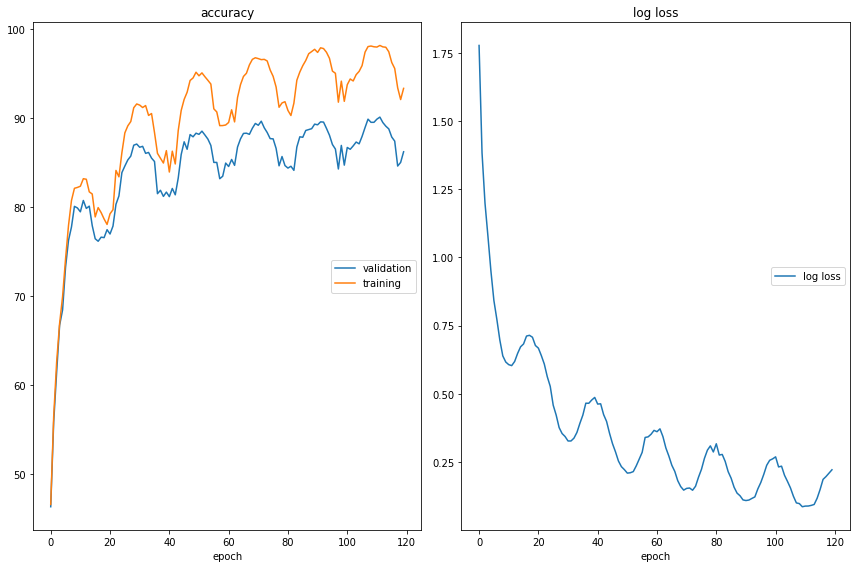

accuracy
	validation       	 (min:   46.293, max:   90.115, cur:   86.217)
	training         	 (min:   46.552, max:   98.173, cur:   93.347)
log loss
	log loss         	 (min:    0.086, max:    1.778, cur:    0.221)
For epoch 120 the train accuracy is 93 % the test accuracy over the whole test set is 86 %
The average accuracy over 120  runs is 84.19


In [10]:
train_loader, test_loader = load_data()

num_epochs = 120
train(num_epochs)

# checkTransformedImages()

## Class accuracy

Calculate the class accuracy of our best model. The function comes from [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In [11]:
def class_accuracy():
  # load the best model
  model.load_state_dict(torch.load(path))

  train_loader, test_loader = load_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          images = Variable(images.to(device))
          labels = Variable(labels.to(device))
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1


  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

class_accuracy()

RuntimeError: ignored

## Results

| Class Accuracy   | Modified MobileNetV2 | Raw Resnet50 |
| ---------------- | -------------------- | ------------ |
| Tench            | 93.5 %               | 93.0 %       |
| English Springer | 93.4 %               | 95.9 %       |
| Cassette Player  | 89.9 %               | 81.2 %       |
| Chain Saw        | 79.5 %               | 74.4 %       |
| Church           | 91.7 %               | 90.2 %       |
| French Horn      | 86.3 %               | 91.9 %       |
| Garbage Truck    | 91.3 %               | 89.5 %       |
| Gas Pump         | 80.4 %               | 77.8 %       |
| Golf Ball        | 90.0 %               | 84.7 %       |
| Parachute        | 91.0 %               | 89.7 %       |
| Overall          | 89 %                 | 87%          |

## Discussion

1.  **Merging features from different models can bring more insights on new model architecture.**

Based on the experimental results in Table 1. It is found that the modified MobileNetV2 generally outperforms the ResNet50 except for two classes which are “English Springer” and “French Horn”. This implies that combining the Resent residual block with the MobileNetV2 residual block slightly improves accuracy. As we did not use any pre-trained models, the outcome is believed to be unbiased.  

2. **The size and purity of the training dataset can have an impact on the accuracy.** 

As shown in Table 1, the Raw Resnet50 only achieves an 87 % accuracy. However, according to an online database (Meta AI), Resnet50 should have the ability to achieve an accuracy above 95% for the ImageNet dataset. The underperforming reason is suspected to be the insufficient dataset size, as the dataset we used is only a subset of ImageNet. Also, it is found that the training dataset contains about 5% noisy data, which is considered as a major factor in lower accuracy. The presence of the noisy data increases the model complexity and time of learning which degrades the performance of learning algorithms. 

3. **Dropout layers do not necessarily improve the model performance.** 

Although it is mentioned in numerous pieces of literature that dropout regularization is a generic approach to improve the accuracy by reducing overfitting features. However, it is not the case in our experiment. 

It is suspected that batch normalization in our implementation already has a regularizing effect (Ioffe & Szegedy, 2015). Literature also suggests that partial dropout can be harmful in CNN because the spatial relationships encoded in feature maps and activations can be highly correlated, (Jansma, 2022). The comparison of dropouts with different probabilities and batch normalization is shown in Figure 1. 

4. **Fine-tuning hyperparameters is essential to achieve a high accuracy.**  

During our experiment, we tried to run ResNet50 with a consistent 0.001 learning rate. It is found that the accuracy could only barely reach 80%. However, after we implemented the CosineAnnealingLR scheduler, the accuracy went up to 87%. This outcome matches the results from another research study (Peng & Wang, 2012).  

## Conclusion

_Fengyi or someone else write this as well_

## Bibliography/Data Sources

He, K., Zhang, X., Ren, S., & Sun, J. (2015). Deep Residual Learning for Image Recognition. Microsoft Research. 

Ioffe, S., & Szegedy, C. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. Google Inc. 

Jansma, H. (2022, August 23). Don’t Use Dropout in Convolutional Networks. Retrieved from KDnuggets: https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html 

Meta AI. (n.d.). Image Classification on ImageNet. Retrieved from https://paperswithcode.com/sota/image-classification-on-imagenet?metric=Top%205%20Accuracy&tag_filter=3 

Peng, P., & Wang, J. (2012). How to fine-tune deep neural networks in few-shot learning? Hangzhou: Zhejiang University. 

Sandler, M., Howard, A., Zhu, M., Zhmoginov, A., & Chen, L.-C. (n.d.). MobileNetV2: Inverted Residuals and Linear Bottlenecks. Google Inc. 

## Appendix

[Raw Results From Experimentation](https://docs.google.com/document/d/1VH5TaP6iL8CWjEFiAHPcl2VOgWTknwL8fDhfYtvaaAQ/edit?usp=sharing)